# ***Data Processing***

V. 1.15

In [1]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import re
import pylab as pl
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
#from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')

Basic data type-conversions after loading the csv.
Important changes made include removing any "Budget" data that shows currency other "United States".

In [2]:
movies = pd.DataFrame(pd.read_csv("movies.csv"))
movies = movies.drop(['Unnamed: 0'], axis=1)

movies.loc[movies["Year"] == '    ', ['Year']] = 0 
movies["Year"] = movies["Year"].fillna(-1)
movies["Year"] = movies["Year"].astype(float)

movies = movies[~movies['Budget'].astype(str).str.contains('Budget:')]
movies = movies[~movies['Budget'].astype(str).str.contains('Trivia')]
movies["Budget"] = movies["Budget"].str.replace(',','')
movies["Budget"] = movies["Budget"].fillna(-1)
movies["Budget"] = movies["Budget"].astype(float)

movies["Gross US"] = movies["Gross US"].str.replace(',','')
movies["Gross US"] = movies["Gross US"].fillna(-1)
movies["Gross US"] = movies["Gross US"].astype(float)

movies["Gross WW"] = movies["Gross WW"].str.replace(',','')
movies["Gross WW"] = movies["Gross WW"].fillna(-1)
movies["Gross WW"] = movies["Gross WW"].astype(float)

movies["Language"] = movies["Language"].fillna(-1)

movies["Rating"] = movies["Rating"].fillna('Unrated')

movies["Duration"] = movies["Duration"].fillna(-1)
movies=movies.rename(columns = {'Duration':'Duration_Minutes'})

movies=movies.rename(columns = {'Average Rating':'Average_Rating'})
print(movies.dtypes)

Name                   object
Year                  float64
Genres                 object
Rating                 object
Duration_Minutes      float64
Actors                 object
Director               object
Average_Rating        float64
Budget                float64
Opening Weekend       float64
Gross US              float64
Gross WW              float64
Language               object
Production Company     object
dtype: object


# Relevant Ratings considered in the dataset :

G – General Audiences

PG – Parental Guidance Suggested

PG-13 – Parents Strongly Cautioned

NC-17 – Adults Only	

R – Restricted


In [3]:
#Cleaning Rating
drop_tv = ['TV-14' ,'TV-G', 'TV-MA', 'TV-Y', 'TV-PG' , 'TV-Y7' , 'GP' , 'Passed' , 'X' ]  #Removing TV shows/X rated movies
movies=movies[~movies['Rating'].isin(drop_tv)]
movies['Rating'] = movies['Rating'].replace({'Not Rated':'Unrated'})
movies["Rating"].value_counts()

R          3974
PG-13      2020
PG         1570
Unrated    1360
G           252
NC-17        20
Name: Rating, dtype: int64

In [4]:
#Cleaning Year
to_drop = [2020,2021,2024] #Removing future releases (no data available)
movies=movies[~movies['Year'].isin(to_drop)] 

In [5]:
#Calculating Profit/Loss for each movie
movies["Profit"] = movies["Gross US"]+movies["Gross WW"]- movies["Budget"]
movies["Status"]= np.where(movies['Profit']>1, True, False)
movies["Status"].value_counts()

True     4942
False    4242
Name: Status, dtype: int64

Cleaning up some of the columns:

In [6]:
movies["Genres"] = movies["Genres"].str.replace('[','')
movies["Genres"] = movies["Genres"].str.replace(']','')
movies["Genres"] = movies["Genres"].str.replace("'",'')
movies["Actors"] = movies["Actors"].str.replace('[','')
movies["Actors"] = movies["Actors"].str.replace(']','')
movies["Actors"] = movies["Actors"].str.replace("'",'')
movies["Director"] = movies["Director"].str.replace('[','')
movies["Director"] = movies["Director"].str.replace(']','')
movies["Director"] = movies["Director"].str.replace("'",'')
movies["Production Company"] = movies["Production Company"].str.replace('[','')
movies["Production Company"] = movies["Production Company"].str.replace(']','')
movies["Production Company"] = movies["Production Company"].str.replace("'",'')
movies["Language"] = movies["Language"].str.replace('[','')
movies["Language"] = movies["Language"].str.replace(']','')
movies["Language"] = movies["Language"].str.replace("'",'')
# movies.head()

In [7]:
indexNames = movies[ (movies['Year'] == 0) & (movies['Rating'] == 'Unrated')&(movies['Budget'] != -1) ].index
# Delete these row indexes from dataFrame
movies.drop(indexNames , inplace=True)

In [8]:
g = (movies.Genres.str.split(',', expand=True).stack().to_frame(name='genre'))
g.index = g.index.droplevel(1)
g["genre"] = g["genre"].str.replace(' ','')
g["genre"] = g["genre"].str.replace('}','')
# m=movies.join(g)
movies=pd.concat([movies, g], axis=1)
movies.head().T

,0,0,1,1,1
Name,Pulp Fiction,Pulp Fiction,The Amazing Spider-Man 2,The Amazing Spider-Man 2,The Amazing Spider-Man 2
Year,1994,1994,2014,2014,2014
Genres,"Crime, Drama","Crime, Drama","Action, Adventure, Sci-Fi","Action, Adventure, Sci-Fi","Action, Adventure, Sci-Fi"
Rating,R,R,PG-13,PG-13,PG-13
Duration_Minutes,154,154,142,142,142
Actors,"John Travolta, Uma Thurman, Samuel L. Jackson,...","John Travolta, Uma Thurman, Samuel L. Jackson,...","Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...","Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...","Andrew Garfield, Emma Stone, Jamie Foxx, Paul ..."
Director,Quentin Tarantino,Quentin Tarantino,Marc Webb,Marc Webb,Marc Webb
Average_Rating,8.9,8.9,6.6,6.6,6.6
Budget,8e+06,8e+06,2e+08,2e+08,2e+08
Opening Weekend,9.31188e+06,9.31188e+06,9.16083e+07,9.16083e+07,9.16083e+07


In [9]:
genre_count = movies['genre'].value_counts().sort_index()
drop_geners = ['Musical' ,'Sport', 'History', 'Music','News', 'Reality-TV', 'Talk-Show' , '' , 'creator' , 'director' , 'Short' , 'actor' ] #Removing TV shows/reality/sport
movies=movies[~movies['genre'].isin(drop_geners)]
movies["genre"].value_counts()

Drama          4876
Comedy         3475
Thriller       2500
Romance        1994
Action         1885
Crime          1713
Adventure      1438
Horror         1122
Sci-Fi          988
Fantasy         956
Mystery         890
Family          825
Biography       799
War             369
Animation       336
Documentary     282
Western         174
Name: genre, dtype: int64

In [10]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24622 entries, 0 to 9836
Data columns (total 17 columns):
Name                  24622 non-null object
Year                  24622 non-null float64
Genres                24622 non-null object
Rating                24622 non-null object
Duration_Minutes      24622 non-null float64
Actors                24622 non-null object
Director              24622 non-null object
Average_Rating        24622 non-null float64
Budget                24622 non-null float64
Opening Weekend       14844 non-null float64
Gross US              24622 non-null float64
Gross WW              24622 non-null float64
Language              24331 non-null object
Production Company    24622 non-null object
Profit                24622 non-null float64
Status                24622 non-null bool
genre                 24622 non-null object
dtypes: bool(1), float64(8), object(8)
memory usage: 3.2+ MB


In [11]:
movies.isnull().sum()

Name                     0
Year                     0
Genres                   0
Rating                   0
Duration_Minutes         0
Actors                   0
Director                 0
Average_Rating           0
Budget                   0
Opening Weekend       9778
Gross US                 0
Gross WW                 0
Language               291
Production Company       0
Profit                   0
Status                   0
genre                    0
dtype: int64

In [12]:
movies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company,Profit,Status,genre
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,107928762.0,213928762.0,"English, Spanish, French","Miramax, ABandApart, JerseyFilms",313857524.0,True,Crime
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,107928762.0,213928762.0,"English, Spanish, French","Miramax, ABandApart, JerseyFilms",313857524.0,True,Drama
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,202853933.0,708982323.0,English,"MarvelEnterprises, AviAradProductions, Columbi...",711836256.0,True,Action
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,202853933.0,708982323.0,English,"MarvelEnterprises, AviAradProductions, Columbi...",711836256.0,True,Adventure
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,202853933.0,708982323.0,English,"MarvelEnterprises, AviAradProductions, Columbi...",711836256.0,True,Sci-Fi


In [13]:
new = movies["Actors"].str.split(",", n = 5, expand = True)
new
movies["Cast1"]=new[0]
movies["Cast2"]=new[1]
movies["Cast3"]=new[2]
movies["Cast4"]=new[3]
# movies.drop(columns =["Actors"], inplace = True) 

In [14]:
l = movies["Language"].str.split(",", n = 5, expand = True)

movies["Lang1"]=l[0]
movies["Lang2"]=l[1]
movies["Lang3"]=l[2]
movies["Lang4"]=l[3]


In [15]:
director = movies["Director"].str.split(", ", n = 4, expand = True) 
movies["Director_One"]= director[0] 
movies["Director_two"]= director[1]
movies["Director_three"]= director[2]
movies["Director_four"]= director[3] 
# movies.drop(columns =["Director"], inplace = True) 
z=movies.Director_One.value_counts()
z1 = z.to_dict() #converts to dictionary
movies['CountOfMoviesDirected'] = movies['Director_One'].map(z1) 


In [16]:
movies.columns

Index(['Name', 'Year', 'Genres', 'Rating', 'Duration_Minutes', 'Actors',
       'Director', 'Average_Rating', 'Budget', 'Opening Weekend', 'Gross US',
       'Gross WW', 'Language', 'Production Company', 'Profit', 'Status',
       'genre', 'Cast1', 'Cast2', 'Cast3', 'Cast4', 'Lang1', 'Lang2', 'Lang3',
       'Lang4', 'Director_One', 'Director_two', 'Director_three',
       'Director_four', 'CountOfMoviesDirected'],
      dtype='object')

In [17]:
movies.Name.value_counts() #multiple movies with same name ..but each was made in different year with different cast
df=movies.groupby(['Name'], as_index=False).size()
df.to_frame().head()

,0
Name,
$5 a Day,2
(500) Days of Summer,3
*batteries not included,4
...and justice for all.,3
.45,3


# Visualization

In the plot below we  grouped the data by genre and then took the mean of the Budget, ordered it, and plotted the 10 Genres with the highest average Budget.

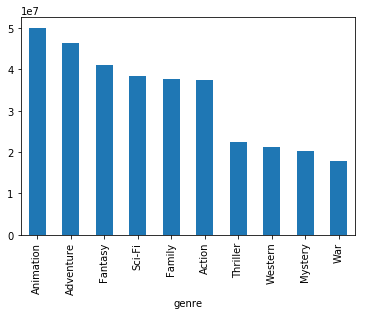

In [18]:
movies.groupby("genre").Budget.mean().sort_values(ascending=False)[:10].plot.bar()

Plotting Top 10 profitable Genres

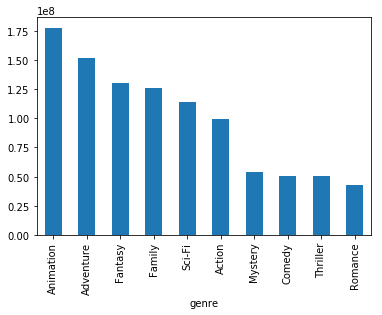

In [19]:
movies.groupby("genre").Profit.mean().sort_values(ascending=False)[:10].plot.bar()

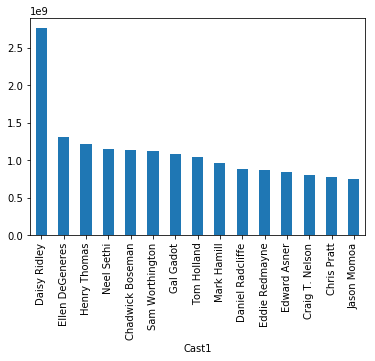

In [72]:
movies.groupby("Cast1").Profit.mean().sort_values(ascending=False)[:15].plot.bar()

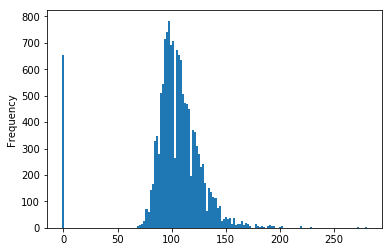

In [76]:
# create a histogram of duration, choosing an “appropriate” number of bins
movies['Duration_Minutes'].plot(kind='hist', bins=150)

The above plot shows us that most of the movies lie in the range of 75-150 mins

Count how many movies have average ratings :

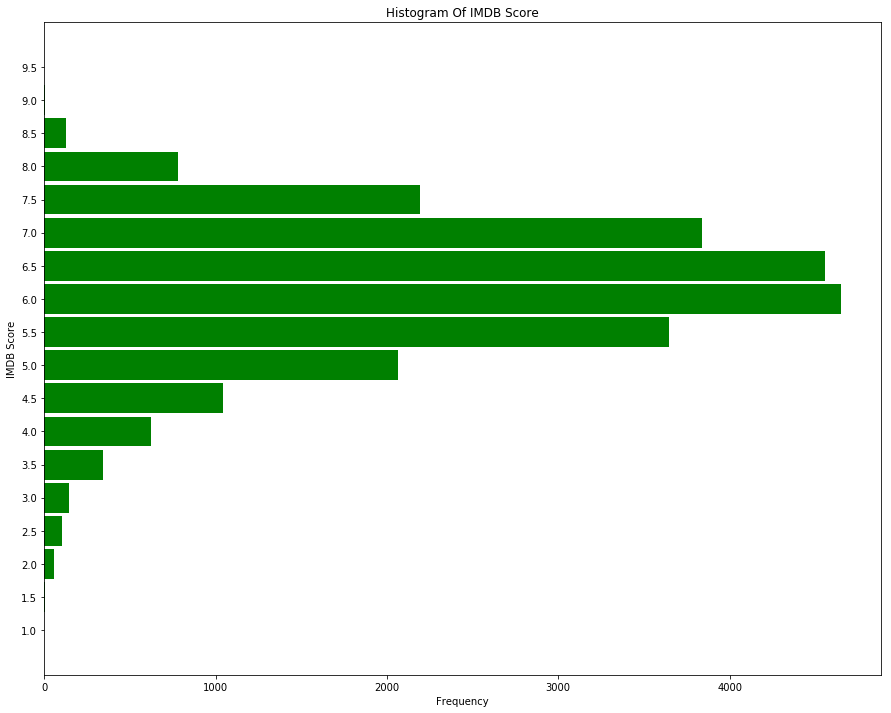

In [22]:
# movies[['Average_Rating' ,'Name']].groupby('Average_Rating').count()
imdbScore=[[]]
x=[]

for i in pl.frange(1,9.5,.5):
    imdbScore.append(len(movies.Average_Rating[(movies.Average_Rating>=i) & (movies.Average_Rating<i+.5)]))
    x.append(i)

del(imdbScore[0])

plt.figure(figsize=(15,12))
plt.title("Histogram Of IMDB Score")
plt.ylabel("IMDB Score")
plt.xlabel('Frequency')
plt.barh(x,imdbScore,height=.45 ,color='green')
plt.yticks(x)
plt.show()

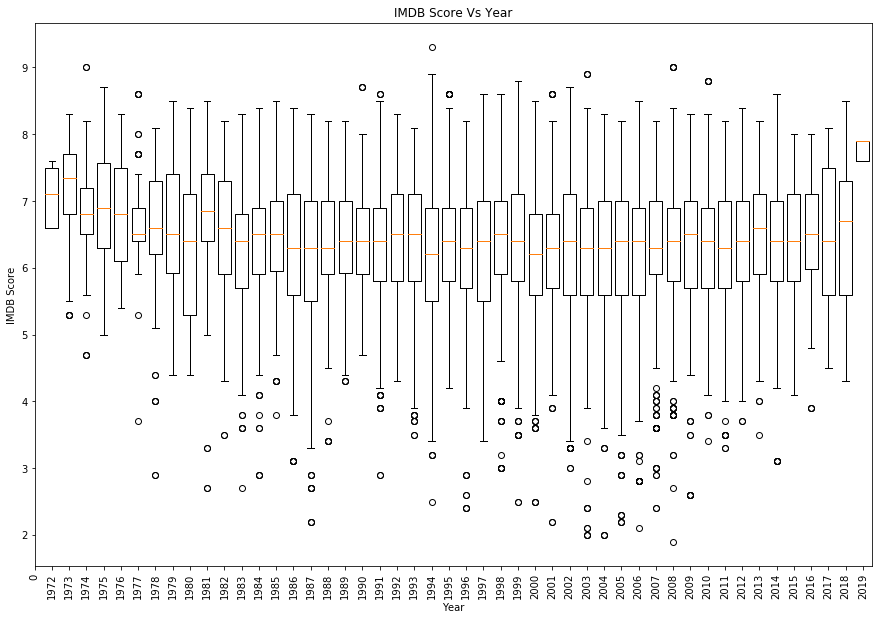

In [77]:
data=movies.dropna()
year=(movies.Year.unique()).astype(int)
year=sorted(year)
yearImdbScore=[]
numOfMovieByYear=[]

for i in year:
    tmp=movies.Average_Rating[movies.Year==i]
    yearImdbScore.append(tmp)
    numOfMovieByYear.append(len(tmp))

plt.figure(figsize=(15,10))
plt.title("IMDB Score Vs Year")
plt.ylabel("IMDB Score")
plt.xlabel('Year')
plt.boxplot(yearImdbScore,widths=.75)
year=list(np.insert(year,0,0))
plt.xticks(range(len(year)),year,rotation=90,fontsize=10)
plt.show()


Text(0, 0.5, 'Title Count')

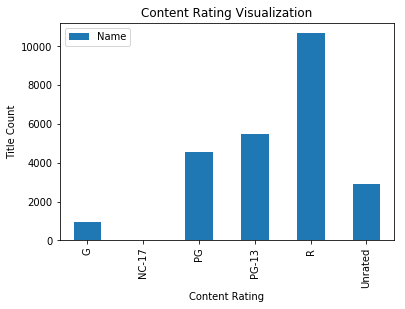

In [24]:
# use a visualization to display that same data, including a title and x and y labels
movies[['Rating' ,'Name']].groupby('Rating').count().plot(kind='bar', title='Content Rating Visualization')
plt.xlabel('Content Rating')
plt.ylabel('Title Count')

In [25]:
# calculate the average star rating for movies 2 hours or longer,
# and compare that with the average star rating for movies shorter than 2 hours
print('Avg. star rating for movies 2 hours or longer: ', movies[movies['Duration_Minutes'] >= 120]['Average_Rating'].mean(), 
 '\nAvg. star rating for movies shorter than 2 hours: ', movies[movies['Duration_Minutes'] < 120]['Average_Rating'].mean())

Avg. star rating for movies 2 hours or longer:  6.972851127074552 
Avg. star rating for movies shorter than 2 hours:  6.029662375516156


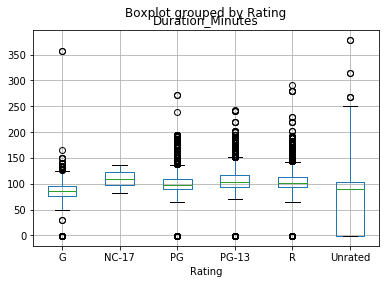

In [26]:
# visualize the relationship between rating and duration
movies.boxplot(column='Duration_Minutes', by='Rating')

# Check for Duplicacy

In [27]:
# check if there are multiple movies with the same title, and if so, determine if they are actually duplicates
result = movies[movies['Name'].isin(movies[movies.duplicated(['Name'])]['Name'])]
result.sort_values('Name')

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,...,Cast4,Lang1,Lang2,Lang3,Lang4,Director_One,Director_two,Director_three,Director_four,CountOfMoviesDirected
4680,$5 a Day,2008.0,"Comedy, Drama",PG-13,90.0,"Christopher Walken, Alessandro Nivola, Sharon ...",Nigel Cole,6.4,-1.0,NaN,...,Dean Cain,English,None,None,None,Nigel Cole,None,None,None,12
4680,$5 a Day,2008.0,"Comedy, Drama",PG-13,90.0,"Christopher Walken, Alessandro Nivola, Sharon ...",Nigel Cole,6.4,-1.0,NaN,...,Dean Cain,English,None,None,None,Nigel Cole,None,None,None,12
6636,(500) Days of Summer,2009.0,"Comedy, Drama, Romance",PG-13,95.0,"Zooey Deschanel, Joseph Gordon-Levitt, Geoffre...",Marc Webb,7.7,7500000.0,834501.0,...,Chlo\\xc3\\xab Grace Moretz,English,French,Swedish,None,Marc Webb,None,None,None,10
6636,(500) Days of Summer,2009.0,"Comedy, Drama, Romance",PG-13,95.0,"Zooey Deschanel, Joseph Gordon-Levitt, Geoffre...",Marc Webb,7.7,7500000.0,834501.0,...,Chlo\\xc3\\xab Grace Moretz,English,French,Swedish,None,Marc Webb,None,None,None,10
6636,(500) Days of Summer,2009.0,"Comedy, Drama, Romance",PG-13,95.0,"Zooey Deschanel, Joseph Gordon-Levitt, Geoffre...",Marc Webb,7.7,7500000.0,834501.0,...,Chlo\\xc3\\xab Grace Moretz,English,French,Swedish,None,Marc Webb,None,None,None,10
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",Matthew Robbins,6.6,-1.0,3326530.0,...,Elizabeth Pe\\xc3\\xb1a,English,None,None,None,Matthew Robbins,None,None,None,14
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",Matthew Robbins,6.6,-1.0,3326530.0,...,Elizabeth Pe\\xc3\\xb1a,English,None,None,None,Matthew Robbins,None,None,None,14
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",Matthew Robbins,6.6,-1.0,3326530.0,...,Elizabeth Pe\\xc3\\xb1a,English,None,None,None,Matthew Robbins,None,None,None,14
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",Matthew Robbins,6.6,-1.0,3326530.0,...,Elizabeth Pe\\xc3\\xb1a,English,None,None,None,Matthew Robbins,None,None,None,14
3426,...and justice for all.,1979.0,"Crime, Drama, Thriller",R,119.0,"Al Pacino, Jack Warden, John Forsythe, Lee Str...",Norman Jewison,7.4,-1.0,NaN,...,Lee Strasberg,English,None,None,None,Norman Jewison,None,None,None,36


In [28]:
movies.columns

Index(['Name', 'Year', 'Genres', 'Rating', 'Duration_Minutes', 'Actors',
       'Director', 'Average_Rating', 'Budget', 'Opening Weekend', 'Gross US',
       'Gross WW', 'Language', 'Production Company', 'Profit', 'Status',
       'genre', 'Cast1', 'Cast2', 'Cast3', 'Cast4', 'Lang1', 'Lang2', 'Lang3',
       'Lang4', 'Director_One', 'Director_two', 'Director_three',
       'Director_four', 'CountOfMoviesDirected'],
      dtype='object')

In [29]:
# calculate the average star rating for each genre, but only include genres with at least 10 movies
genres = movies['genre'].value_counts()[movies['genre'].value_counts() > 10].index
movies[movies['genre'].isin(genres)].groupby('genre')['Average_Rating'].mean()

genre
Action         5.817666
Adventure      6.004103
Animation      6.492857
Biography      7.054819
Comedy         6.035281
Crime          6.292644
Documentary    7.559929
Drama          6.497375
Family         6.129697
Fantasy        5.874059
Horror         5.594118
Mystery        6.240449
Romance        6.260080
Sci-Fi         5.685425
Thriller       6.038600
War            6.661789
Western        6.486782
Name: Average_Rating, dtype: float64

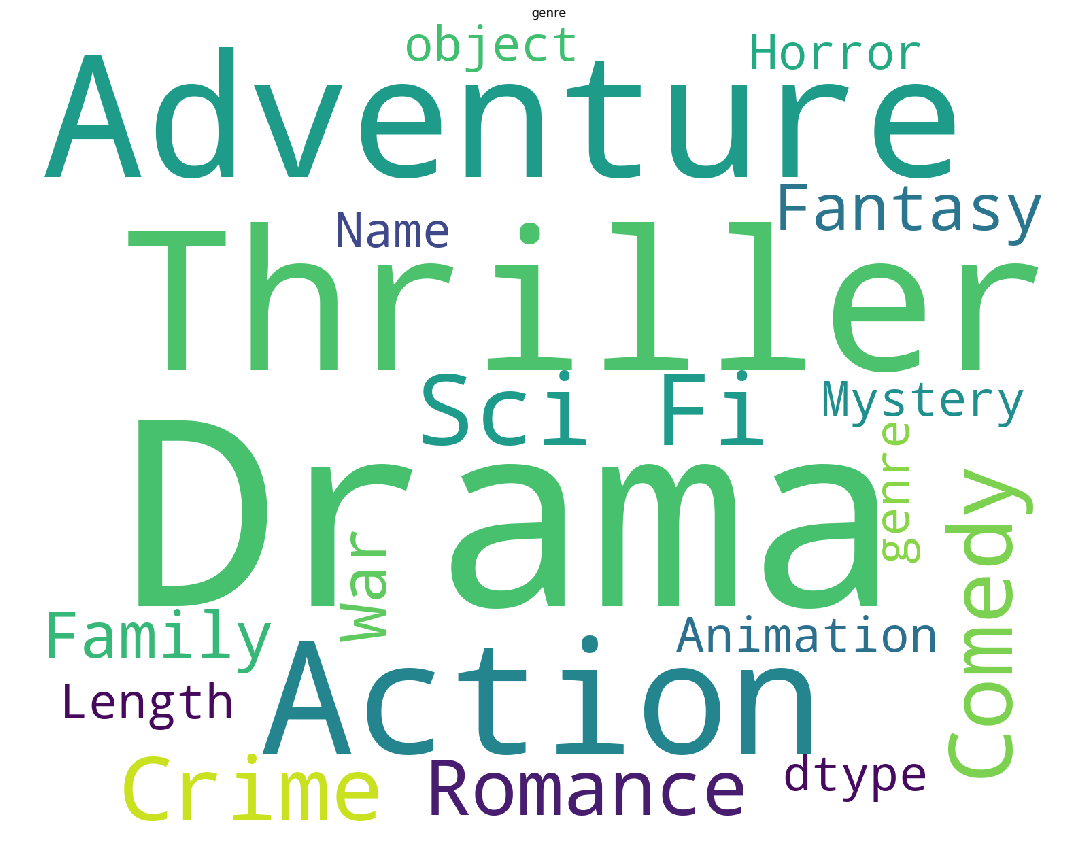

In [30]:
import random
from wordcloud import WordCloud, STOPWORDS
text = (str(movies['genre']))
plt.subplots(figsize=(20,15))
wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1500,
                          height=1200
                         ).generate(text)


plt.imshow(wordcloud)
plt.title('genre')
plt.axis('off')
plt.show()

In [31]:
movies.columns

Index(['Name', 'Year', 'Genres', 'Rating', 'Duration_Minutes', 'Actors',
       'Director', 'Average_Rating', 'Budget', 'Opening Weekend', 'Gross US',
       'Gross WW', 'Language', 'Production Company', 'Profit', 'Status',
       'genre', 'Cast1', 'Cast2', 'Cast3', 'Cast4', 'Lang1', 'Lang2', 'Lang3',
       'Lang4', 'Director_One', 'Director_two', 'Director_three',
       'Director_four', 'CountOfMoviesDirected'],
      dtype='object')

Text(0.5, 1.0, 'TOP 10 Directors OF MOVIES')

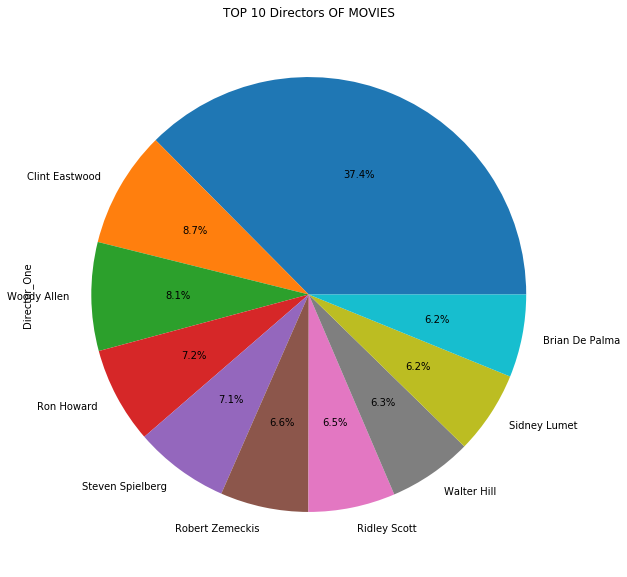

In [32]:
movies.Director_One.value_counts()[:10].plot.pie(autopct='%1.1f%%',figsize=(10,10))
plt.title('TOP 10 Directors OF MOVIES')

Text(0.5, 1.0, 'TOP 10 Actors OF MOVIES')

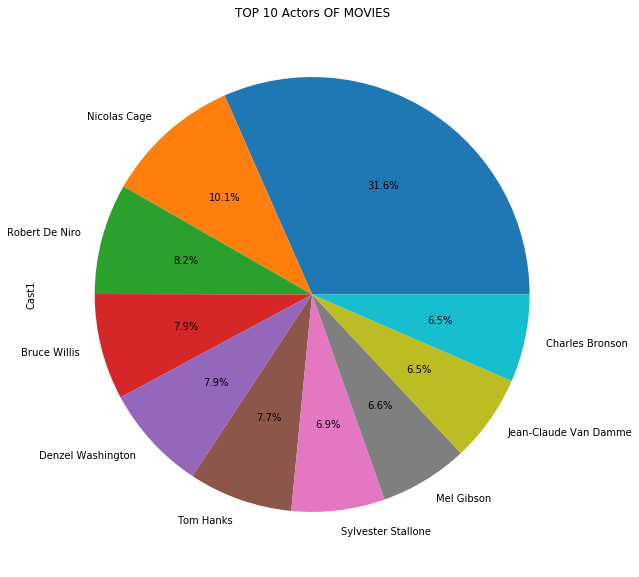

In [33]:
movies.Cast1.value_counts()[:10].plot.pie(autopct='%1.1f%%',figsize=(10,10))
plt.title('TOP 10 Actors OF MOVIES')

In [34]:
#top 10 rating movies 
Sortedrating= movies.sort_values(['Average_Rating'], ascending=False)
Sortedrating.head(10)

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,...,Cast4,Lang1,Lang2,Lang3,Lang4,Director_One,Director_two,Director_three,Director_four,CountOfMoviesDirected
2,The Shawshank Redemption,1994.0,Drama,R,142.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Frank Darabont,9.3,25000000.0,727326.0,...,William Sadler,English,None,None,None,Frank Darabont,None,None,None,12
34,The Dark Knight,2008.0,"Action, Crime, Drama, Thriller",PG-13,152.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",Christopher Nolan,9.0,185000000.0,158411483.0,...,Michael Caine,English,Mandarin,None,None,Christopher Nolan,None,None,None,28
34,The Dark Knight,2008.0,"Action, Crime, Drama, Thriller",PG-13,152.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",Christopher Nolan,9.0,185000000.0,158411483.0,...,Michael Caine,English,Mandarin,None,None,Christopher Nolan,None,None,None,28
34,The Dark Knight,2008.0,"Action, Crime, Drama, Thriller",PG-13,152.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",Christopher Nolan,9.0,185000000.0,158411483.0,...,Michael Caine,English,Mandarin,None,None,Christopher Nolan,None,None,None,28
34,The Dark Knight,2008.0,"Action, Crime, Drama, Thriller",PG-13,152.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",Christopher Nolan,9.0,185000000.0,158411483.0,...,Michael Caine,English,Mandarin,None,None,Christopher Nolan,None,None,None,28
194,The Godfather: Part II,1974.0,"Crime, Drama",R,202.0,"Al Pacino, Robert De Niro, Robert Duvall, Dian...",Francis Ford Coppola,9.0,13000000.0,NaN,...,Diane Keaton,English,Italian,Spanish,Latin,Francis Ford Coppola,None,None,None,37
194,The Godfather: Part II,1974.0,"Crime, Drama",R,202.0,"Al Pacino, Robert De Niro, Robert Duvall, Dian...",Francis Ford Coppola,9.0,13000000.0,NaN,...,Diane Keaton,English,Italian,Spanish,Latin,Francis Ford Coppola,None,None,None,37
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,...,Bruce Willis,English,Spanish,French,None,Quentin Tarantino,None,None,None,26
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,...,Bruce Willis,English,Spanish,French,None,Quentin Tarantino,None,None,None,26
9253,Strangers: The Story of a Mother and Daughter,1979.0,"Drama, actor",Unrated,88.0,"Bette Davis, Gena Rowlands, Ford Rainey, Donal...",Milton Katselas,8.9,-1.0,NaN,...,Donald Moffat,English,None,None,None,Milton Katselas,None,None,None,3


In [35]:
# low rated movies
lowratedmovies= movies.query('(Average_Rating > 0) & (Average_Rating < 3.0)')
lowratedmovies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,...,Cast4,Lang1,Lang2,Lang3,Lang4,Director_One,Director_two,Director_three,Director_four,CountOfMoviesDirected
156,The Cloth,2013.0,"Action, Fantasy, Horror",Unrated,88.0,"Danny Trejo, Perla Rodr\\xc3\\xadguez, Eric Ro...",Justin Price,2.5,4000000.0,NaN,...,Rachele Brooke Smith,English,None,None,None,Justin Price,None,None,None,3
156,The Cloth,2013.0,"Action, Fantasy, Horror",Unrated,88.0,"Danny Trejo, Perla Rodr\\xc3\\xadguez, Eric Ro...",Justin Price,2.5,4000000.0,NaN,...,Rachele Brooke Smith,English,None,None,None,Justin Price,None,None,None,3
156,The Cloth,2013.0,"Action, Fantasy, Horror",Unrated,88.0,"Danny Trejo, Perla Rodr\\xc3\\xadguez, Eric Ro...",Justin Price,2.5,4000000.0,NaN,...,Rachele Brooke Smith,English,None,None,None,Justin Price,None,None,None,3
187,Devils of War,2013.0,"Action, Horror",Unrated,74.0,"Lawrence Anthony, Jerry L. Buxbaum, Jamin Wats...","Eli Dorsey, Eli Dorsey, Bezenby, Kind of okay,...",2.0,-1.0,NaN,...,Jeremiah Grace,English,None,None,None,Eli Dorsey,Eli Dorsey,Bezenby,Kind of okay,2
187,Devils of War,2013.0,"Action, Horror",Unrated,74.0,"Lawrence Anthony, Jerry L. Buxbaum, Jamin Wats...","Eli Dorsey, Eli Dorsey, Bezenby, Kind of okay,...",2.0,-1.0,NaN,...,Jeremiah Grace,English,None,None,None,Eli Dorsey,Eli Dorsey,Bezenby,Kind of okay,2


In [36]:
dir_subset = movies[movies['CountOfMoviesDirected'] > 5]

In [37]:
Sortedrevenue= movies.sort_values(['Budget'], ascending=False)

In [38]:
#top 5 high revenue movies
Sortedrevenue.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,...,Cast4,Lang1,Lang2,Lang3,Lang4,Director_One,Director_two,Director_three,Director_four,CountOfMoviesDirected
9522,Avengers: Infinity War,2018.0,"Action, Adventure, Sci-Fi",PG-13,149.0,"Robert Downey Jr., Chris Hemsworth, Mark Ruffa...","Anthony Russo, Joe Russo",8.5,321000000.0,257698183.0,...,Chris Evans,English,None,None,None,Anthony Russo,Joe Russo,None,None,11
9522,Avengers: Infinity War,2018.0,"Action, Adventure, Sci-Fi",PG-13,149.0,"Robert Downey Jr., Chris Hemsworth, Mark Ruffa...","Anthony Russo, Joe Russo",8.5,321000000.0,257698183.0,...,Chris Evans,English,None,None,None,Anthony Russo,Joe Russo,None,None,11
9522,Avengers: Infinity War,2018.0,"Action, Adventure, Sci-Fi",PG-13,149.0,"Robert Downey Jr., Chris Hemsworth, Mark Ruffa...","Anthony Russo, Joe Russo",8.5,321000000.0,257698183.0,...,Chris Evans,English,None,None,None,Anthony Russo,Joe Russo,None,None,11
9408,Justice League,2017.0,"Action, Adventure, Fantasy, Sci-Fi",PG-13,120.0,"Ben Affleck, Gal Gadot, Jason Momoa, Ezra Miller",Zack Snyder,6.5,300000000.0,93842239.0,...,Ezra Miller,English,Irish,Russian,Icelandic,Zack Snyder,None,None,None,25
9408,Justice League,2017.0,"Action, Adventure, Fantasy, Sci-Fi",PG-13,120.0,"Ben Affleck, Gal Gadot, Jason Momoa, Ezra Miller",Zack Snyder,6.5,300000000.0,93842239.0,...,Ezra Miller,English,Irish,Russian,Icelandic,Zack Snyder,None,None,None,25


# Correlation heatmap

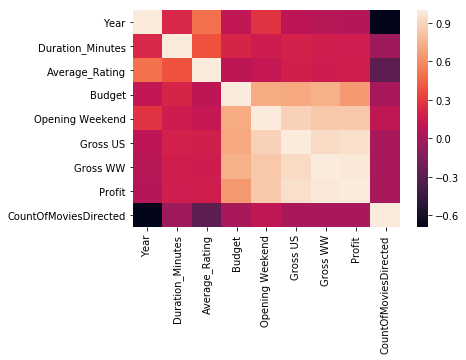

In [39]:
col = list(movies.describe().columns)
features=col
features
sns.heatmap(movies[features].corr())
plt.show()

In [40]:
correlation=movies.corr()
correlation

,Year,Duration_Minutes,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Profit,Status,CountOfMoviesDirected
Year,1.000000,0.220767,0.494260,0.107838,0.278364,0.089157,0.067954,0.063443,0.181120,-0.694157
Duration_Minutes,0.220767,1.000000,0.386839,0.207225,0.163834,0.198617,0.175447,0.168387,0.157816,-0.029580
Average_Rating,0.494260,0.386839,1.000000,0.094556,0.120391,0.181257,0.163036,0.176036,0.182558,-0.285424
Budget,0.107838,0.207225,0.094556,1.000000,0.719234,0.713744,0.742947,0.645244,0.264580,0.009807
Opening Weekend,0.278364,0.163834,0.120391,0.719234,1.000000,0.885164,0.846269,0.844191,0.260679,0.105554
Gross US,0.089157,0.198617,0.181257,0.713744,0.885164,1.000000,0.925435,0.952404,0.400416,0.012889
Gross WW,0.067954,0.175447,0.163036,0.742947,0.846269,0.925435,1.000000,0.983934,0.321043,0.010136
Profit,0.063443,0.168387,0.176036,0.645244,0.844191,0.952404,0.983934,1.000000,0.344471,0.010651
Status,0.181120,0.157816,0.182558,0.264580,0.260679,0.400416,0.321043,0.344471,1.000000,-0.075036
CountOfMoviesDirected,-0.694157,-0.029580,-0.285424,0.009807,0.105554,0.012889,0.010136,0.010651,-0.075036,1.000000


# Checking that we can replace Rating with Monitary Value

We are going to check to see if each rating has a different enough distribution to justify replacing each Rating with their respective mean. This is going to be done by a two sample t test cross comparing each Rating with eachother, making 7 t tests in total. The actaul replacement will be done in the prediction alogrthm. 

In [41]:
#Need to change all movie ratings that are NC-17 to Unrated
movies["Rating"] = movies["Rating"].replace('NC-17', 'Unrated')
#Removing all movies that dont have a Gross US
movies = movies[movies['Gross US'] > 0]
movies = movies[movies['Budget'] > 0]

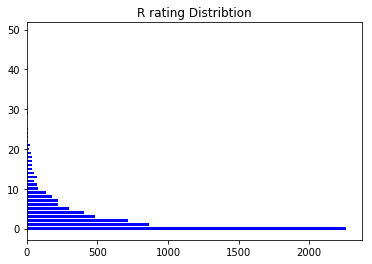

Mean Value:  27731046.84657577


In [42]:
#Graphing R rating vs Gross Earning distrubition
R = movies[movies["Rating"] == 'R']
R = R[R["Gross US"] > 0]
R = R.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingR = R.groupby(pd.cut(R["Gross US"], groups)).count()
y_pos = np.arange(len(groupingR))
plt.barh(y_pos , groupingR["Gross US"], 1/1.5, color="blue")
plt.title("R rating Distribtion")
plt.show()
print("Mean Value: ", R["Gross US"].mean())

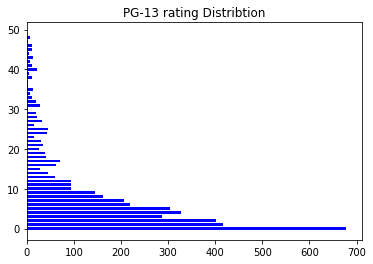

Mean Value:  66627653.53356562


In [43]:
#Graphing PG13 rating vs Gross Earning distrubition
PG13 = movies[movies["Rating"] == 'PG-13']
PG13 = PG13[PG13["Gross US"] > 0]
PG13 = PG13.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingPG13 = PG13.groupby(pd.cut(PG13["Gross US"], groups)).count()
y_pos = np.arange(len(groupingPG13))
plt.barh(y_pos , groupingPG13["Gross US"], 1/1.5, color="blue")
plt.title("PG-13 rating Distribtion")
plt.show()
print("Mean Value: ", PG13["Gross US"].mean())

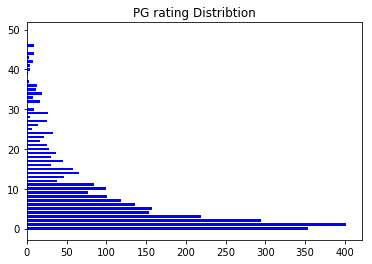

Mean Value:  64459804.39011748


In [44]:
#Graphing PG rating vs Gross Earning distrubition
PG = movies[movies["Rating"] == 'PG']
PG = PG[PG["Gross US"] > 0]
PG = PG.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingPG = PG.groupby(pd.cut(PG["Gross US"], groups)).count()
y_pos = np.arange(len(groupingPG))
plt.barh(y_pos , groupingPG["Gross US"], 1/1.5, color="blue")
plt.title("PG rating Distribtion")
plt.show()
print("Mean Value: ", PG["Gross US"].mean())

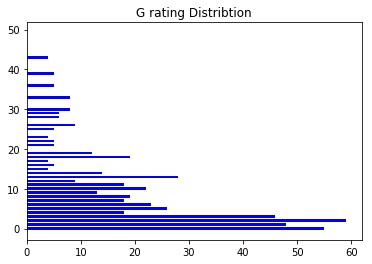

Mean Value:  76789860.8812616


In [45]:
#Graphing G rating vs Gross Earning distrubition
G = movies[movies["Rating"] == 'G']
G = G[G["Gross US"] > 0]
G = G.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingG = G.groupby(pd.cut(G["Gross US"], groups)).count()
y_pos = np.arange(len(groupingG))
plt.barh(y_pos , groupingG["Gross US"], 1/1.5, color="blue")
plt.title("G rating Distribtion")
plt.show()
print("Mean Value: ", G["Gross US"].mean())

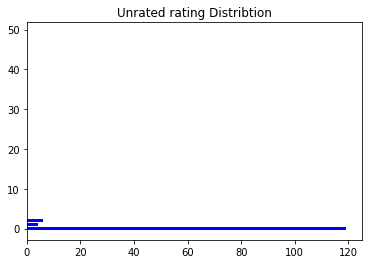

Mean Value:  1845049.3643410853


In [46]:
#Graphing Unrated rating vs Gross Earning distrubition
UN = movies[movies["Rating"] == 'Unrated']
UN = UN[UN["Gross US"] > 0]
UN = UN.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingUN = UN.groupby(pd.cut(UN["Gross US"], groups)).count()
y_pos = np.arange(len(groupingUN))
plt.barh(y_pos , groupingUN["Gross US"], 1/1.5, color="blue")
plt.title("Unrated rating Distribtion")
plt.show()
print("Mean Value: ", UN["Gross US"].mean())

In [47]:
#Checking to see if teh ratings are statiscally different are statistically different
print("R-PG13: ", stats.ttest_ind(R["Gross US"], PG13["Gross US"], equal_var = False))
print("R-PG: ", stats.ttest_ind(R["Gross US"], PG["Gross US"], equal_var = False))
print("R-G: ", stats.ttest_ind(R["Gross US"], G["Gross US"], equal_var = False))
print("PG13-PG: ", stats.ttest_ind(PG13["Gross US"], PG["Gross US"], equal_var = False))
print("PG13-G: ", stats.ttest_ind(PG13["Gross US"], G["Gross US"], equal_var = False))
print("PG-G: ", stats.ttest_ind(PG["Gross US"], G["Gross US"], equal_var = False))
print("UN-R: ", stats.ttest_ind(UN["Gross US"], R["Gross US"], equal_var = False))
print("UN-PG13: ", stats.ttest_ind(UN["Gross US"], PG13["Gross US"], equal_var = False))
print("UN-PG: ", stats.ttest_ind(UN["Gross US"], PG["Gross US"], equal_var = False))
print("UN-G: ", stats.ttest_ind(UN["Gross US"], G["Gross US"], equal_var = False))

R-PG13:  Ttest_indResult(statistic=-26.93717021962157, pvalue=7.651725199969979e-150)
R-PG:  Ttest_indResult(statistic=-25.16653548956893, pvalue=1.068621860834578e-128)
R-G:  Ttest_indResult(statistic=-13.82939828154472, pvalue=1.342323703309665e-37)
PG13-PG:  Ttest_indResult(statistic=1.1122334153957845, pvalue=0.26607662364122076)
PG13-G:  Ttest_indResult(statistic=-2.691723095485679, pvalue=0.007275454241692271)
PG-G:  Ttest_indResult(statistic=-3.2608057442589606, pvalue=0.0011636533936909416)
UN-R:  Ttest_indResult(statistic=-44.4108774518369, pvalue=2.3911836105266265e-219)
UN-PG13:  Ttest_indResult(statistic=-45.70793855861668, pvalue=0.0)
UN-PG:  Ttest_indResult(statistic=-43.6931377515883, pvalue=7e-323)
UN-G:  Ttest_indResult(statistic=-21.190833942210748, pvalue=2.7632351684643257e-73)


Statiscally non of these values with high accuracy are equal to eachother. This allows us to say that each rating has statiscally different value. Lets now replace the Rating with the value of the mean of the rating to signify the value that the rating has upon the movie.

In [48]:
movies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,...,Cast4,Lang1,Lang2,Lang3,Lang4,Director_One,Director_two,Director_three,Director_four,CountOfMoviesDirected
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,...,Bruce Willis,English,Spanish,French,None,Quentin Tarantino,None,None,None,26
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,...,Bruce Willis,English,Spanish,French,None,Quentin Tarantino,None,None,None,26
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,...,Paul Giamatti,English,None,None,None,Marc Webb,None,None,None,10
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,...,Paul Giamatti,English,None,None,None,Marc Webb,None,None,None,10
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,...,Paul Giamatti,English,None,None,None,Marc Webb,None,None,None,10


# PREDICTION

In [50]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split
from sklearn.datasets import load_boston
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [51]:
movies.fillna(value=0,axis=1,inplace=True)
print(movies.set_index(['Budget','Opening Weekend','Gross US'])
         .stack()
         .reset_index(name='value')
         )

            Budget  Opening Weekend     Gross US                level_3  \
0        8000000.0        9311882.0  107928762.0                   Name   
1        8000000.0        9311882.0  107928762.0                   Year   
2        8000000.0        9311882.0  107928762.0                 Genres   
3        8000000.0        9311882.0  107928762.0                 Rating   
4        8000000.0        9311882.0  107928762.0       Duration_Minutes   
5        8000000.0        9311882.0  107928762.0                 Actors   
6        8000000.0        9311882.0  107928762.0               Director   
7        8000000.0        9311882.0  107928762.0         Average_Rating   
8        8000000.0        9311882.0  107928762.0               Gross WW   
9        8000000.0        9311882.0  107928762.0               Language   
10       8000000.0        9311882.0  107928762.0     Production Company   
11       8000000.0        9311882.0  107928762.0                 Profit   
12       8000000.0       

In [55]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14248 entries, 0 to 9835
Data columns (total 30 columns):
Name                     14248 non-null object
Year                     14248 non-null float64
Genres                   14248 non-null object
Rating                   14248 non-null object
Duration_Minutes         14248 non-null float64
Actors                   14248 non-null object
Director                 14248 non-null object
Average_Rating           14248 non-null float64
Budget                   14248 non-null float64
Opening Weekend          14248 non-null float64
Gross US                 14248 non-null float64
Gross WW                 14248 non-null float64
Language                 14248 non-null object
Production Company       14248 non-null object
Profit                   14248 non-null float64
Status                   14248 non-null bool
genre                    14248 non-null object
Cast1                    14248 non-null object
Cast2                    14248 non-null 

In [52]:
features = ['Rating', 'Genres', 'Cast1', 'Cast2' ,'Cast3', 'Cast4','Director_One','Director_two','Director_three']
target = ['Profit']
PROFIT_MARIGINE = 1

In [53]:
train, test = train_test_split(movies,test_size=0.30)

In [54]:
#Fill the training and test data with require information
train_x = train[features] 
train_y = train[target]
train_gross = train['Profit']
test_x = test[features]
test_y = test[target]

Here we are going to change the Rating value to the mean value of the Gross US made by all movies in that rating. Please not that we do NOT take the movies in the test array into the mean value of the Gross US. Furthermore we only replace the movies with the mean value of the train movies. This means that any test movie rating are replace with the training moviie's mean gross US for that rating.

In [56]:
R = train_gross[train_x["Rating"] == 'R']
PG13 = train_gross[train_x["Rating"] == 'PG-13']
PG = train_gross[train_x["Rating"] == 'PG']
G = train_gross[train_x["Rating"] == 'G']
UN = train_gross[train_x["Rating"] == 'Unrated']
#a baseline for the value of movies made in that rating
train_x["Rating"] = train_x["Rating"].replace('R', R.mean())
train_x["Rating"] = train_x["Rating"].replace('PG-13', PG13.mean())
train_x["Rating"] = train_x["Rating"].replace('PG', PG.mean())
train_x["Rating"] = train_x["Rating"].replace('G', G.mean())
train_x["Rating"] = train_x["Rating"].replace('Unrated', UN.mean())
train_x["Rating"] = train_x["Rating"].astype(float)
#a baseline for the value of movies made in that rating
test_x["Rating"] = test_x["Rating"].replace('R', R.mean())
test_x["Rating"] = test_x["Rating"].replace('PG-13', PG13.mean())
test_x["Rating"] = test_x["Rating"].replace('PG', PG.mean())
test_x["Rating"] = test_x["Rating"].replace('G', G.mean())
test_x["Rating"] = test_x["Rating"].replace('Unrated', UN.mean())
test_x["Rating"] = test_x["Rating"].astype(float)

In [57]:
# calculate the average Gross US for each genre, but only include genres with at least 10 movies
cast = ["Director_One", "Director_two", "Director_three"]
for c in cast:
    dirList = train_x[c].unique()
    unknownCast = test_x[~(test_x[c].isin(dirList))][c].unique()

    dirvalues = pd.DataFrame()
    dirvalues["List"] = dirList
    dirvalues["Value"] = dirList
    for g in dirList:
        dirvalues.loc[dirvalues['List'] == g, "Value"] = train_gross[train_x[c] == g].mean()
    for g in dirList:
        train_x[c] = train_x[c].replace(g, dirvalues[dirvalues["List"] == g]["Value"].mean())
        test_x[c] = test_x[c].replace(g, dirvalues[dirvalues["List"] == g]["Value"].mean())
    avg = train_gross.mean()
    for g in unknownCast:
        test_x[c] = test_x[c].replace(g, avg)

In [58]:
cast = ["Cast1", "Cast2", "Cast3", "Cast4"]
for c in cast:
    castList = train_x[c].unique()
    unknownCast = test_x[~(test_x[c].isin(castList))][c].unique()

    castValues = pd.DataFrame()
    castValues["List"] = castList
    castValues["Value"] = castList
    for g in castList:
        castValues.loc[castValues['List'] == g, "Value"] = train_gross[train_x[c] == g].mean()
    for g in castList:
        train_x[c] = train_x[c].replace(g, castValues[castValues["List"] == g]["Value"].mean())
        test_x[c] = test_x[c].replace(g, castValues[castValues["List"] == g]["Value"].mean())
    avg = train_gross.mean()
    for g in unknownCast:
        test_x[c] = test_x[c].replace(g, avg)

In [59]:
# calculate the average Gross US for each genre, but only include genres with at least 10 movies
genreList = train_x['Genres'].unique()
unknownGenres = test_x[~(test_x['Genres'].isin(genreList))]['Genres'].unique()

genreValues = pd.DataFrame()
genreValues["List"] = genreList
genreValues["Value"] = genreList
for g in genreList:
    genreValues.loc[genreValues['List'] == g, "Value"] = train_gross[train_x['Genres'] == g].mean()
for g in genreList:
    train_x["Genres"] = train_x["Genres"].replace(g, genreValues[genreValues["List"] == g]["Value"].mean())
    test_x["Genres"] = test_x["Genres"].replace(g, genreValues[genreValues["List"] == g]["Value"].mean())
avg = train_gross.mean()
for g in unknownGenres:
    test_x["Genres"] = test_x["Genres"].replace(g, avg)

In [60]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_x_std = pd.DataFrame(sc.fit_transform(train_x),columns=features)
test_x_std = pd.DataFrame(sc.transform(test_x), columns=features)


In [61]:
train_x_std.head(2)

,Rating,Genres,Cast1,Cast2,Cast3,Cast4,Director_One,Director_two,Director_three
0,-1.073949,-0.587604,-0.565933,0.395956,-0.571358,-0.498570,-0.104526,-0.103743,-0.038849
1,-1.073949,-0.397694,-0.603436,-0.253631,-0.607848,-0.530411,-0.382648,-0.103743,-0.038849


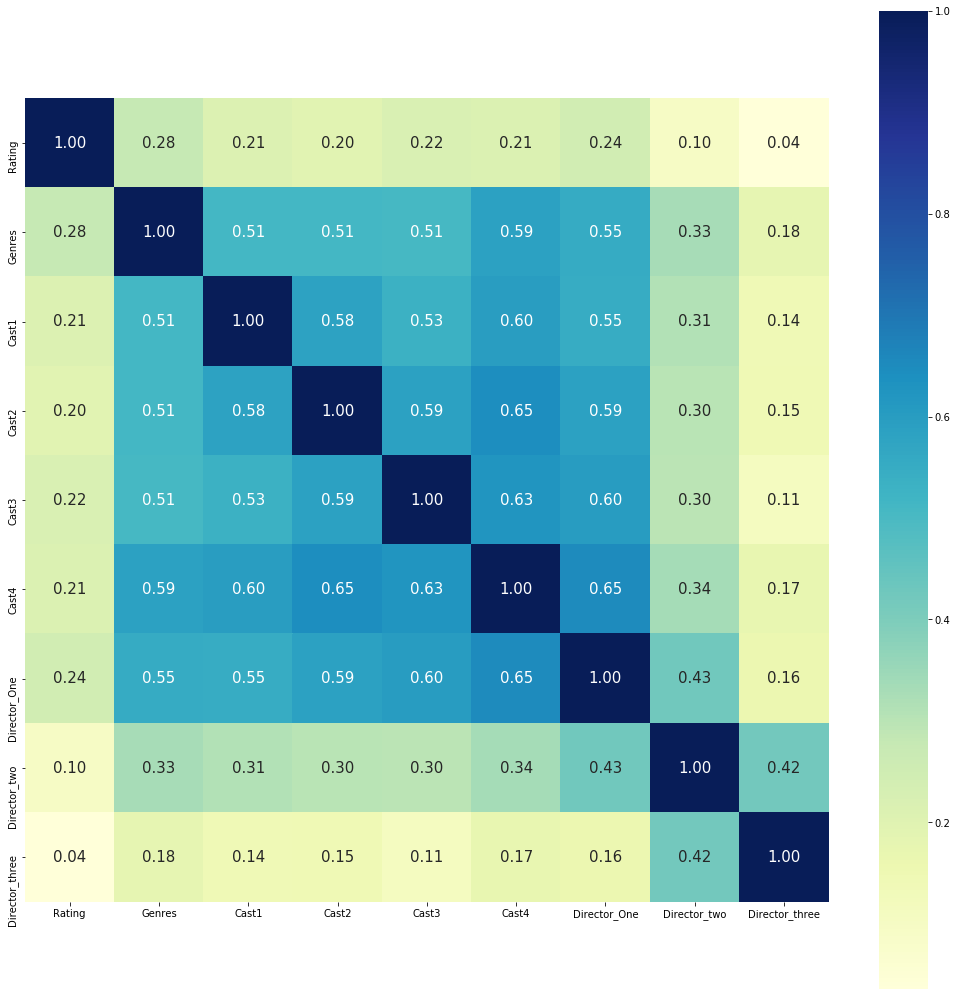

In [62]:
corr = train_x_std.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
            cmap= 'YlGnBu')
plt.show()

In [63]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(train_x_std,train_y)
predicted_rating = model.predict(test_x_std)

In [64]:
for i in range(0, len(predicted_rating)):
    if(predicted_rating[i][0] > PROFIT_MARIGINE):
        predicted_rating[i][0] = 1
    else:
        predicted_rating[i][0] = 0
test_y = np.where(test_y['Profit']> PROFIT_MARIGINE, True, False)


In [65]:
#Calculate cross valiation scores
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, train_x_std, train_y, cv=5)
print("Linear regression accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Linear regression accuracy: 0.84 (+/- 0.02)


In [66]:
#Calculate score of the model
from sklearn import metrics 
r2score  = metrics.r2_score(test_y,predicted_rating)
print('R2 score is: {}'.format(round(r2score,2)))
accuracy = 0
for i in range(0, len(predicted_rating)):
    if(predicted_rating[i][0]  == test_y[i]):
        accuracy = accuracy + 1
print(accuracy/len(predicted_rating))


R2 score is: -0.24
0.7281871345029239


In [67]:
clf = svm.SVC(gamma=0.001, C=100)
train_y = np.where(train_y['Profit']> PROFIT_MARIGINE, True, False)
clf.fit( train_x, train_y)
predictions = clf.predict(test_x)
confuse = metrics.confusion_matrix(test_y, predictions)
print(confuse)
accuracy = (confuse[0][0] + confuse[1][1])/(confuse[0][0] + confuse[1][0] + confuse[0][1] + confuse[1][1])
print("Accuracy of SVC: ", accuracy)

[[1164  225]
 [   0 2886]]
Accuracy of SVC:  0.9473684210526315


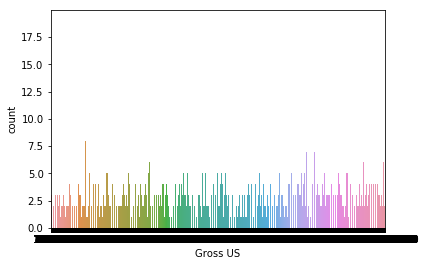

In [68]:

high_score_data= movies.loc[movies['Gross US']>=3] #only count of movies with score>= 3.0
sns.countplot(high_score_data['Gross US'],label='Gross US')
plt.show()

In [69]:
#Calculate cross valiation scores
from sklearn.model_selection import cross_val_score
print(test_y.shape)
scores = cross_val_score(rf, test_x_std,np.ravel(test_y), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print('Maximum score in cross valuation is: %0.2f'%(scores.max()))

(4275,)


NameError: name 'rf' is not defined

In [70]:
ser = pd.Series(rf.feature_importances_,index=features) #feature importance
ser.sort_values(ascending=False,inplace=True)
ser.plot(kind='bar')

NameError: name 'rf' is not defined